In [1]:
from functools import partial
from dataclasses import dataclass
from typing import Any, Callable
from __future__ import annotations
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils.extmath import cartesian
from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import classification_report

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

$$
\renewcommand{\paren}[1]{\left(#1\right)}
\renewcommand{\brac}[1]{\left[#1\right]}
\renewcommand{\sumi}[]{\sum_{i=1}^N}
\renewcommand{\htheta}[]{\hat{\theta}}
\renewcommand{\hthetami}[]{\htheta_{- i}}
\renewcommand{\hthetamie}[]{\hthetami(\epsilon)}
\renewcommand{\nablat}[]{\nabla_{\theta}}
\renewcommand{\nablatt}[]{\nabla_{\theta}^2}
\renewcommand{\evale}[1]{\left.#1\right|_{\epsilon=0}}
$$
- $z = (x, y)$
- $L(z, \theta) = L(y, f(x, \theta))$
- $R(\theta) = \sumi L(z_i, \theta)$

$$
\htheta = \arg\min_{\theta \in \Theta}\sumi L(z_i, \theta)
$$

$$
\hthetami = \arg\min_{\theta \in \Theta} \sum_{j \neq i} L(z_j, \theta)
$$

$$
\hthetamie = \arg\min_{\theta \in \Theta} \sumi L(z_j, \theta) - \epsilon L(z_i, \theta)
$$

- $\epsilon = 0$のとき：$\hthetami(0) = \htheta$
- $\epsilon = 1$のとき：$\hthetami(1) = \hthetami$

となることがわかります。

$\epsilon$を変化させたときにどのくらい誤差が変化するかを知りたいわけなんで、

$$
\begin{align}
    \evale{\frac{d L(z, \hthetami(\epsilon))}{d \epsilon}}
    &= \evale{\nablat L(z, \hthetamie)^\top \frac{d \hthetamie}{d\epsilon}}
\end{align}
$$
がわかればいい。つまり、$\frac{d \hthetamie}{d\epsilon}$が知りたい。








$\hthetamie$の性質を調べるために、そもそも$\hthetamie$がどうやって計算されていたかを思い出すと、
$$
\hthetamie = \arg\min_{\theta \in \Theta} \sumi R(\theta) - \epsilon L(z_i, \theta)
$$
でした。
この後の操作を可能にするために、$R(\theta)$は$\theta$に関してstrongly convexで2階微分可能であることを仮定します。

$\hthetamie$は目的関数を最小化する値なので、1階条件
$$
    \nablat R(\hthetamie) - \nablat L(z_i, \hthetamie)\epsilon = 0
$$
を満たします。

ここで、左辺を$\htheta$の周りで1階のテイラー展開すると以下を得ます。
$$
 \paren{\nablat R(\htheta) - \nablat L(z_i, \htheta)\epsilon} + \paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}\paren{\hthetamie - \htheta} + \mathrm{residual}
$$
ところで、$\htheta$は$R(\theta)$を最小化する値なので、$\nablat R(\htheta) = 0$です。ついでに剰余項を無視して近似すると
$$
0 \approx - \nablat L(z_i, \htheta)\epsilon + \paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}\paren{\hthetamie - \htheta}
$$
なので、整理すると
$$
\paren{\hthetamie - \htheta} \approx \paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}^{-1}\nablat L(z_i, \htheta)\epsilon
$$
となります。

<!-- $\epsilon = 0$のときは$\hthetami(0) = \htheta$だっとことを思い出すと、 -->
$\epsilon$を$0$からちょっとだけ動かしたときに$\hthetamie$が$\htheta$からどれだけ離れるかを知りたいので、両辺を$\epsilon$で微分して$\epsilon=0$で評価します。


$$
\begin{align}
    \evale{\frac{d\paren{\hthetamie - \htheta}}{d\epsilon}} &\approx \evale{\paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}^{-1}\nablat L(z_i, \htheta)
    +\paren{\nablatt R(\htheta) - \nablatt L(z_i, \htheta)\epsilon}^{-2}\nablatt L(z_i, \htheta)\nablat L(z_i, \htheta)\epsilon}\\
    \evale{\frac{d\hthetamie}{d\epsilon}} &\approx \nablatt R(\htheta)^{-1}\nablat L(z_i, \htheta)
\end{align}
$$


これを元の式に戻すと
$$
\begin{align}
    \evale{\frac{d L(z, \hthetami(\epsilon))}{d \epsilon}} \approx \nablat L(z, \htheta)^\top\nablatt R(\htheta)^{-1}\nablat L(z_i, \htheta)
\end{align}
$$

を得る。これをInfluence Function $\mathcal{I}_i(z)$と呼んでいます。
$$
\mathcal{I}_i(z) := \nablat L(z, \htheta)^\top\nablatt R(\htheta)^{-1}\nablat L(z_i, \htheta)
$$

特徴量が1つだけの単純な線形回帰モデル
$$
y = x\theta + u
$$
を考えます。損失関数は二乗誤差とします。
このとき、Influence Functionに必要なパーツはそれぞれ以下で計算できます。

$$
\begin{align}
   L(z, \theta) &= (y - x\theta)^2, \\
   \nablat L(z, \theta) &= -2(y - x\theta)x,\\
   R(\theta) &= \sumi(y_i - x_i\theta)^2,\\
   \nablat R(\theta) &= -2\sumi(y_i - x_i\theta)x_i,\\
   \nablatt R(\theta) &= 2\sumi x_i^2,\\ 
   \htheta &= \frac{\sumi x_iy_i}{\sumi x_i^2}
\end{align}
$$



$$
\begin{align}
\mathcal{I}_i(z) &:= \nablat L(z, \htheta)^\top\nablatt R(\htheta)^{-1}\nablat L(z_i, \htheta)\\
&= \paren{-2\paren{y - x\htheta}x} \paren{2\sumi x_i^2}^{-1} \paren{-2\paren{y_i - x_i\htheta}x_i}\\
&= \frac{2\paren{\paren{y - x\htheta}x}\paren{\paren{y_i - x_i\htheta}x_i}}{\sumi x_i^2}
\end{align}
$$

特に、インスタンス$i$の予測値に与える影響は$z = z_i = (x_i, y_i)$の場合なので、
$$
\mathcal{I}_i(z_i) = \frac{2\paren{\paren{y_i - x_i\htheta}x_i}^2}{\sumi x_i^2}
$$
となります。

In [370]:
def generate_simulation_data(
    n_incetances: int,
) -> tuple[np.ndarray, np.ndarray]:
    """"""
    x = np.random.normal(0, 1, n_incetances)
    u = np.random.normal(0, 0.1, n_incetances)

    y = x + u

    return (x, y)


x, y = generate_simulation_data(n_incetances=100)

In [390]:
def estimate_theta(x: np.ndarray, y: np.ndarray) -> float:
    """単回帰係数を推定する"""
    return (x @ y) / (x @ x)


def calc_influence(
    x: np.ndarray, y: np.ndarray, x_train: np.ndarray, y_train: np.ndarray
) -> np.ndarray:
    """influenceを計算する"""
    theta_hat = estimate_theta(x_train, y_train)

    R2 = 2 * (x_train @ x_train)
    L_train = -2 * (y_train - x_train * theta_hat) * x_train
    L = -2 * (y - x * theta_hat) * x

    return L.reshape(-1, 1) @ L_train.reshape(1, -1) / R2


influence = calc_influence(x, y, x, y)

In [383]:
def calc_leave_one_out_error(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """LOOEを計算する"""
    n_incetances = x.shape[0]
    theta_hat = estimate_theta(x, y)

    error = np.zeros((n_incetances, n_incetances))
    for i in range(n_incetances):
        x_loo = np.delete(x, i, 0)
        y_loo = np.delete(y, i, 0)

        theta_hat_loo = estimate_theta(x_loo, y_loo)
        error[i, :] = (y - x * theta_hat_loo) ** 2 - (y - x * theta_hat) ** 2

    return error


looe = calc_leave_one_out_error(x, y)

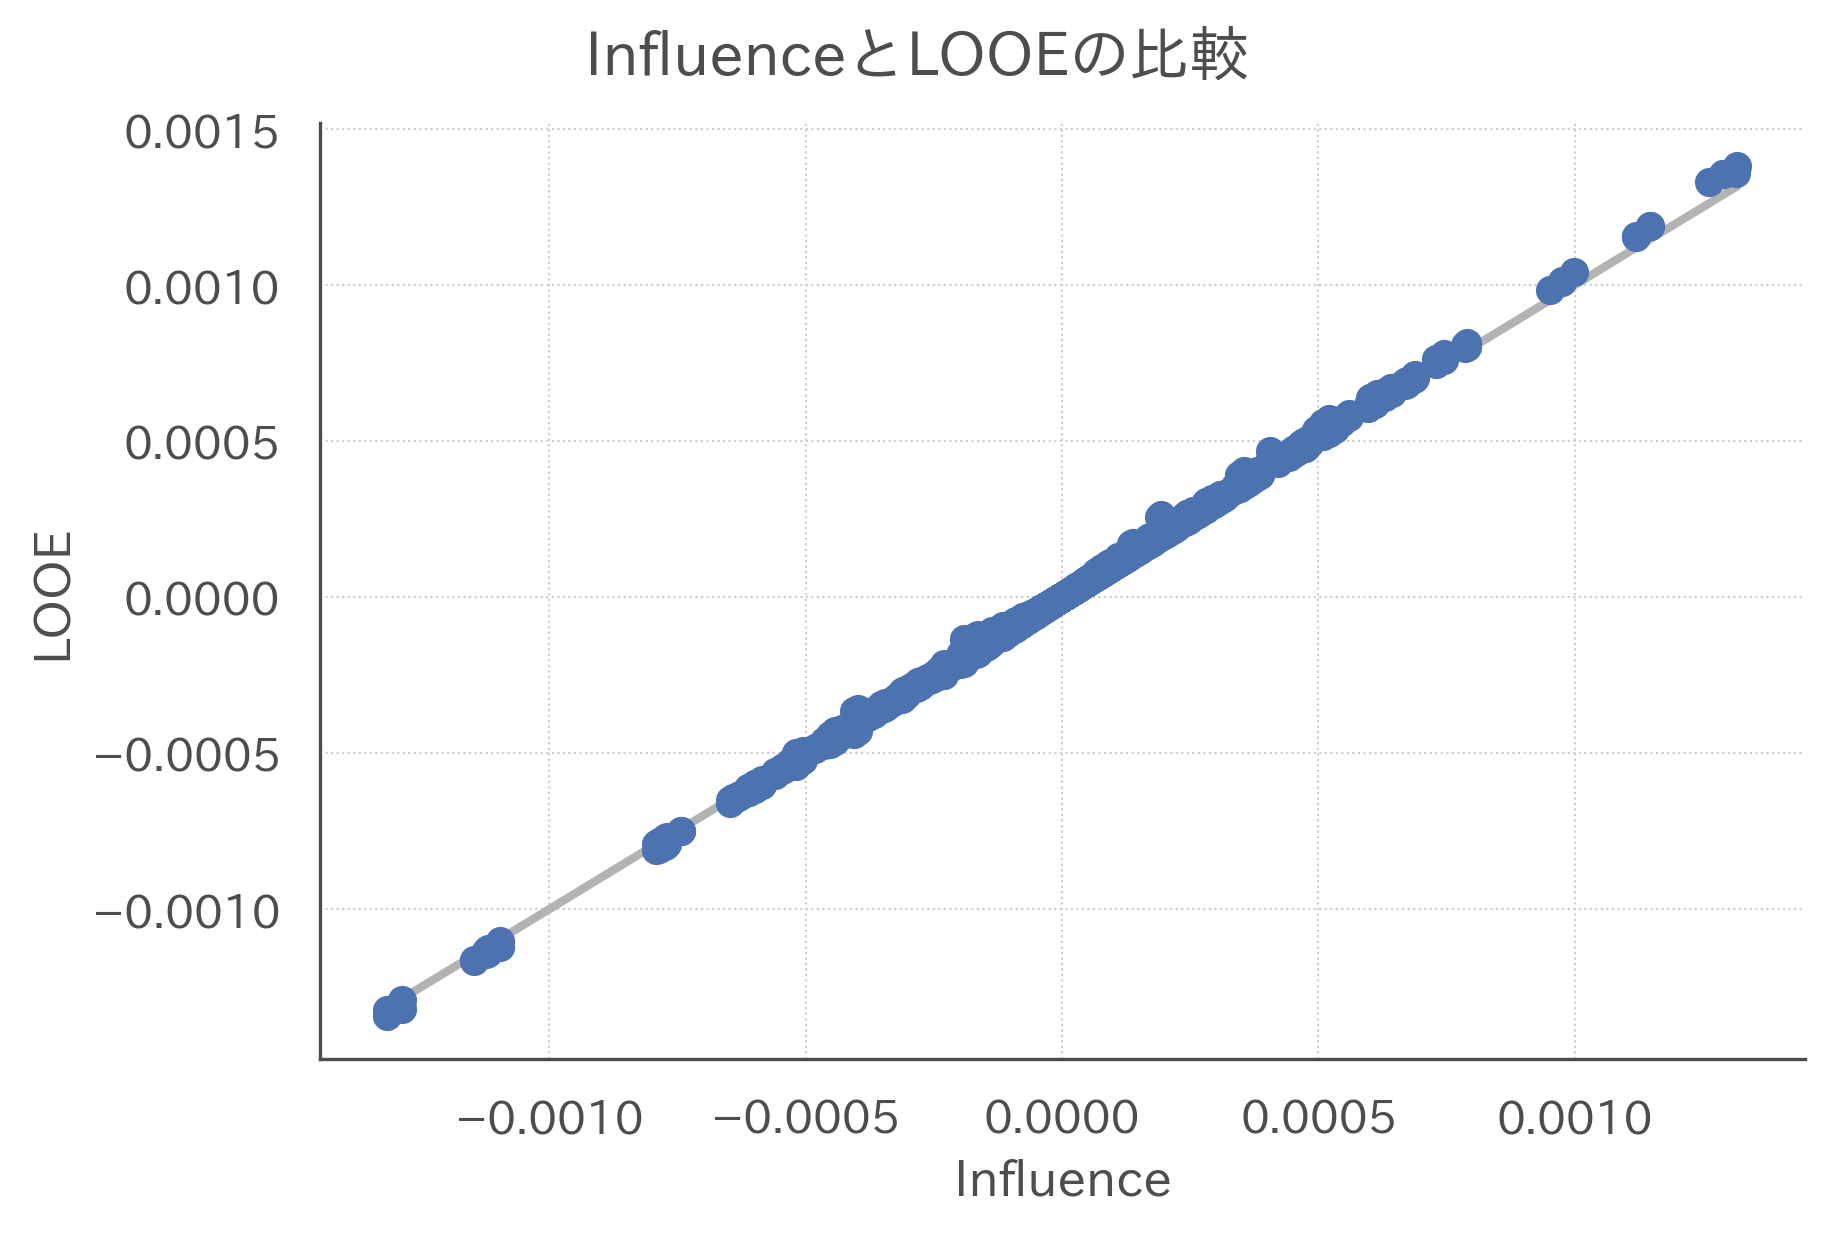

In [407]:
def draw_scatter_with_line(x: np.ndarray, y: np.ndarray, xlabel: str, ylabel: str, title: str):
    
    xx = np.linspace(x.min(), x.max(), num=50)
    
    fig, ax = plt.subplots()
    ax.plot(xx, xx, c='.7', linewidth=2, zorder=1)
    ax.scatter(x, y, zorder=2)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)
    fig.show()
    
draw_scatter_with_line(influence.flatten(), looe.flatten(), "Influence", "LOOE", "InfluenceとLOOEの比較")